# Handwritten OCR Pipeline — End-to-End Exploration

Interactive notebook to test, visualize, and evaluate the LangGraph-based OCR pipeline.

**Sections:**
1. Setup & Configuration
2. LangGraph Visualization
3. Image Loading & Preprocessing Visualization
4. Step-by-Step Graph Execution
5. Full Pipeline Run
6. Trace & Execution Analysis
7. Evaluation (CER, WER, LLM correction)

## 1. Setup & Configuration

In [1]:
import sys
import time
import json
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ensure the project root is on the path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from ocr_agent import config
from ocr_agent.graph import build_ocr_graph
from ocr_agent.state import OCRState
from ocr_agent.trace import Trace
from ocr_agent.tools import (
    preprocess_image,
    run_ocr,
    unload_ocr_model,
    compare_versions,
    merge_versions,
    evaluate,
    tier1_metrics,
    cer,
    wer,
    normalize_text,
)
from ocr_agent.agents import run_critic, run_editor, run_arbitrator

print(f"Project root: {PROJECT_ROOT}")
print(f"OCR model: {config.OLMOCR_MODEL}")
print(f"LLM model: {config.OLLAMA_MODEL}")
print(f"Preprocessing strategies: {len(config.PREPROCESSING_STRATEGIES)}")

Project root: /Users/marwanbounassif/Documents/repos/handwritten-ocr
OCR model: allenai/olmOCR-2-7B-1025
LLM model: qwen3:32b
Preprocessing strategies: 6


In [2]:
# --- Configuration ---
# Change these to point at your test image
IMAGE_PATH = PROJECT_ROOT / "data" / "input" / "test_notes.jpg"
# Set to a ground-truth file path (or None)
GROUND_TRUTH_PATH = None  # e.g. PROJECT_ROOT / "data" / "input" / "test_notes_gt.md"

assert IMAGE_PATH.exists(), f"Image not found: {IMAGE_PATH}"
print(f"Image: {IMAGE_PATH}")
print(f"Ground truth: {GROUND_TRUTH_PATH}")

Image: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/test_notes.jpg
Ground truth: None


## 2. LangGraph Visualization

Render the compiled graph to see the full pipeline topology.

In [3]:
graph = build_ocr_graph()

# Draw the graph as a Mermaid diagram
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	initial_ocr(initial_ocr)
	critic(critic)
	editor(editor)
	reocr(reocr)
	accept(accept)
	plateau(plateau)
	max_iterations(max_iterations)
	__end__([<p>__end__</p>]):::last
	__start__ --> initial_ocr;
	critic -.-> accept;
	critic -. &nbsp;edit&nbsp; .-> editor;
	critic -.-> max_iterations;
	critic -.-> plateau;
	critic -.-> reocr;
	editor --> critic;
	initial_ocr --> critic;
	reocr -.-> critic;
	reocr -.-> max_iterations;
	accept --> __end__;
	max_iterations --> __end__;
	plateau --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



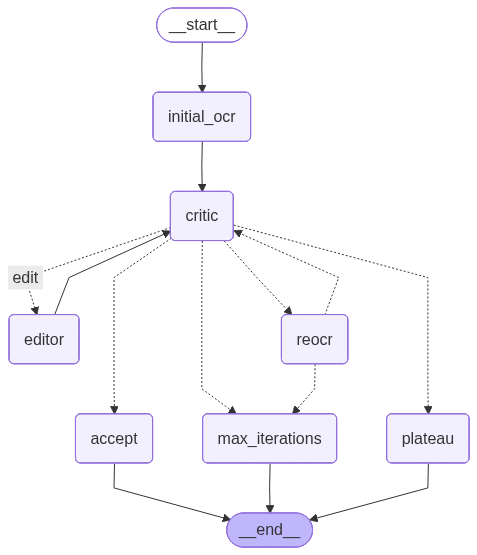

In [4]:
# Render as a PNG image (requires graphviz or pygraphviz installed)
try:
    png_bytes = graph.get_graph().draw_mermaid_png()
    from IPython.display import Image as IPImage, display
    display(IPImage(png_bytes))
except Exception as e:
    print(f"PNG rendering failed ({e}). Use the Mermaid text above instead.")
    print("Tip: paste the Mermaid output into https://mermaid.live to see it.")

## 3. Image Loading & Preprocessing Visualization

See the original image and all preprocessing strategies side-by-side.

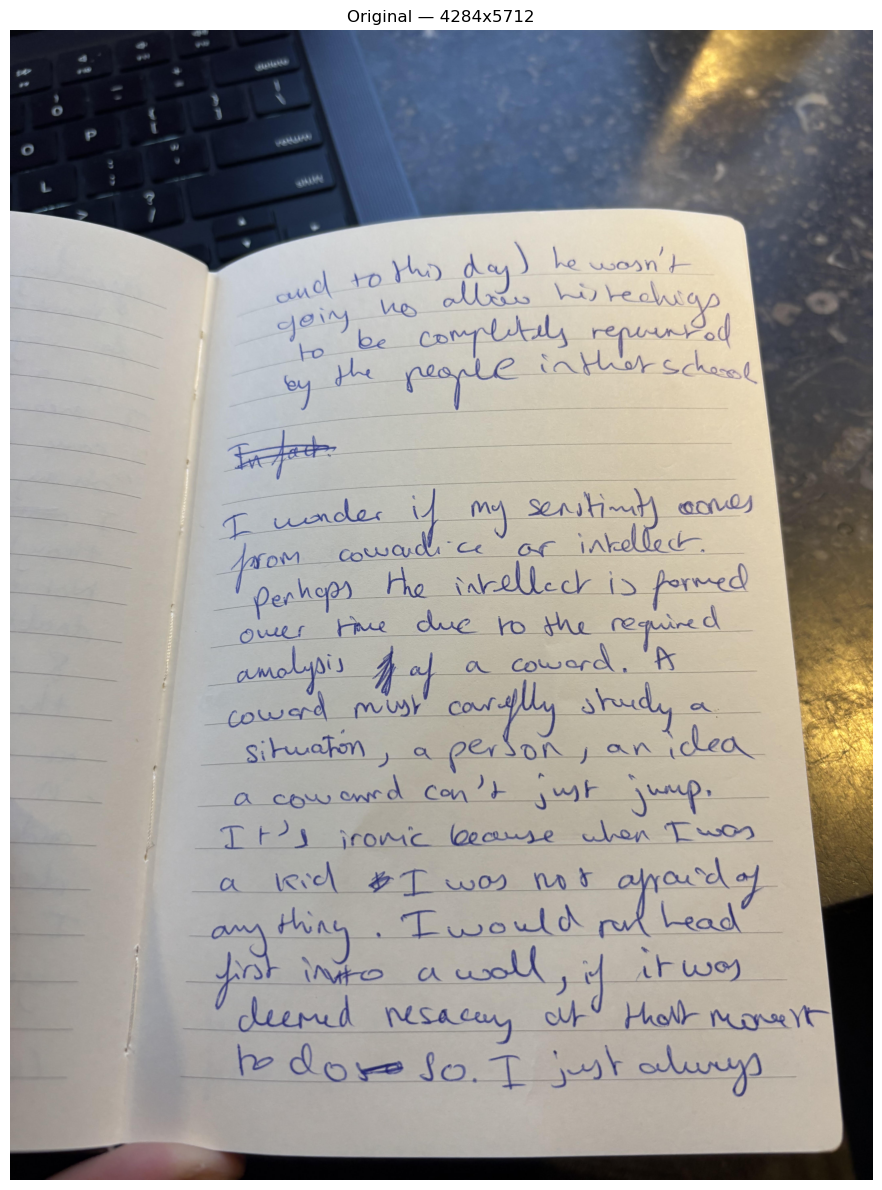

In [5]:
# Show the original image
original = Image.open(IMAGE_PATH)
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.imshow(original)
ax.set_title(f"Original — {original.size[0]}x{original.size[1]}")
ax.axis("off")
plt.tight_layout()
plt.show()

  [preprocess] Applying binarize+high_contrast...
  [preprocess] Applying deskew+high_contrast+sharpen...
  [preprocess] Applying deskew+denoise+high_contrast...
  [preprocess] Applying deskew+remove_lines+high_contrast...
  [preprocess] Applying deskew+high_contrast+binarize...


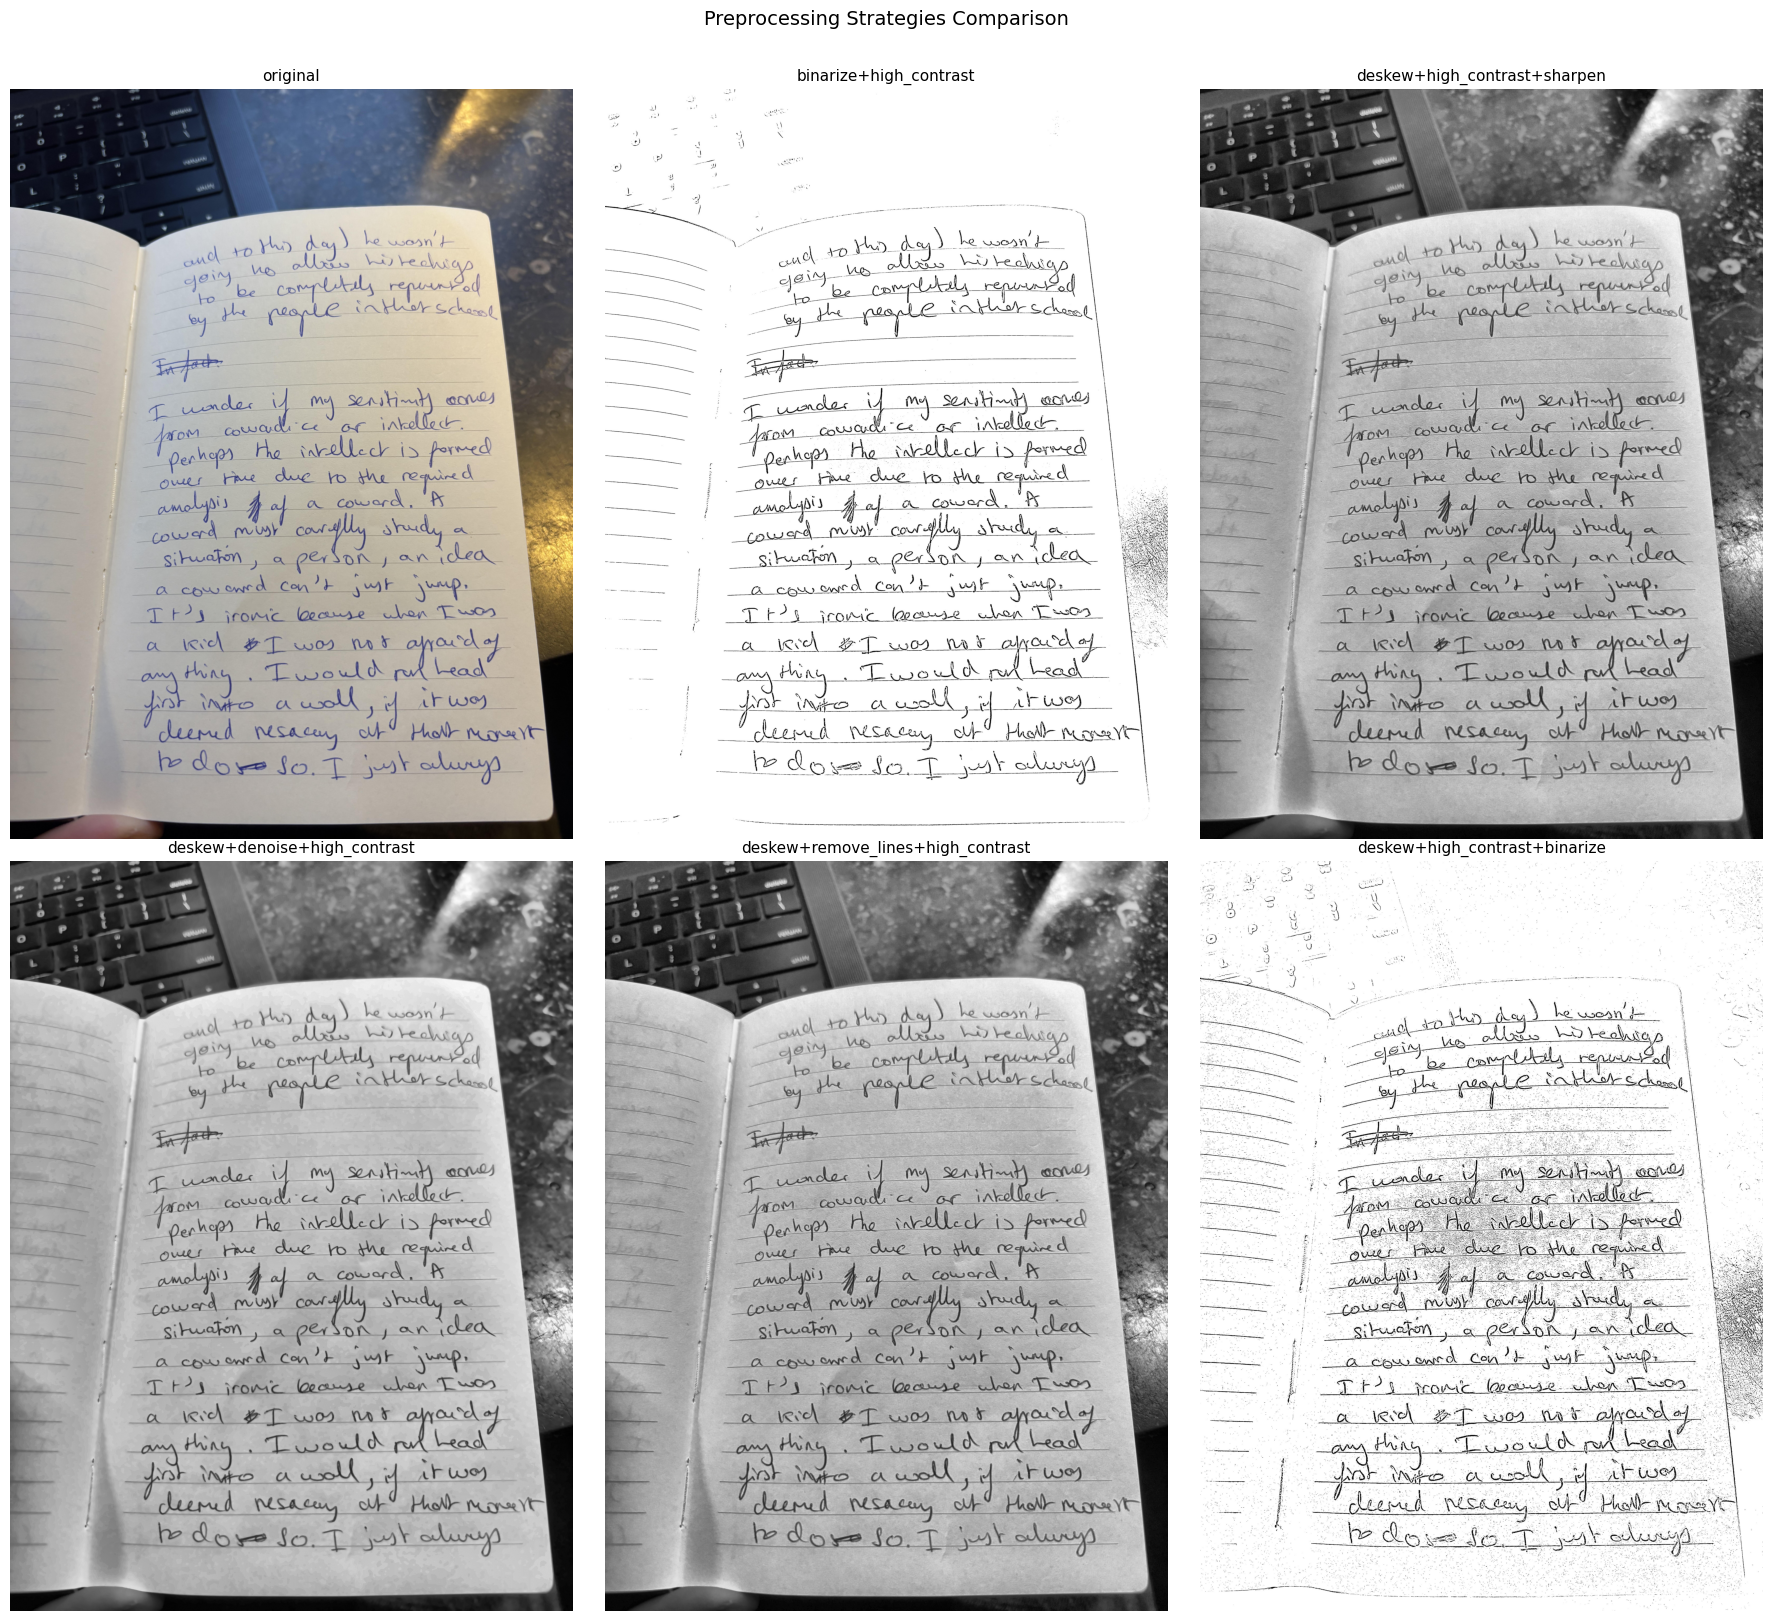


6 strategies rendered.
  original: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/test_notes.jpg
  binarize+high_contrast: /var/folders/wb/xc8m71yx5yn_wkcv0lcym2280000gn/T/ocr_binarize+high_contrast_jbkd3538.jpg
  deskew+high_contrast+sharpen: /var/folders/wb/xc8m71yx5yn_wkcv0lcym2280000gn/T/ocr_deskew+high_contrast+sharpen_2uxyjh1x.jpg
  deskew+denoise+high_contrast: /var/folders/wb/xc8m71yx5yn_wkcv0lcym2280000gn/T/ocr_deskew+denoise+high_contrast_v_r_s874.jpg
  deskew+remove_lines+high_contrast: /var/folders/wb/xc8m71yx5yn_wkcv0lcym2280000gn/T/ocr_deskew+remove_lines+high_contrast_pio3iklo.jpg
  deskew+high_contrast+binarize: /var/folders/wb/xc8m71yx5yn_wkcv0lcym2280000gn/T/ocr_deskew+high_contrast+binarize_2x4ylkrz.jpg


In [6]:
# Apply all preprocessing strategies and display them
strategies = config.PREPROCESSING_STRATEGIES
n = len(strategies)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 8 * rows))
axes = axes.flatten() if n > 1 else [axes]

preprocessed_paths = {}
for idx, strategy in enumerate(strategies):
    label = "+".join(strategy) if isinstance(strategy, list) else strategy
    path = preprocess_image(str(IMAGE_PATH), strategy)
    preprocessed_paths[label] = path
    img = Image.open(path)
    axes[idx].imshow(img, cmap="gray" if img.mode == "L" else None)
    axes[idx].set_title(label, fontsize=11)
    axes[idx].axis("off")

# Hide unused axes
for idx in range(n, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle("Preprocessing Strategies Comparison", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print(f"\n{len(preprocessed_paths)} strategies rendered.")
for label, path in preprocessed_paths.items():
    print(f"  {label}: {path}")

### 3b. Individual Transform Comparison

Zoom into specific transforms to compare before/after.

  [preprocess] Applying high_contrast...
  [preprocess] Applying binarize...
  [preprocess] Applying sharpen...
  [preprocess] Applying deskew...
  [preprocess] Applying denoise...
  [preprocess] Applying remove_lines...


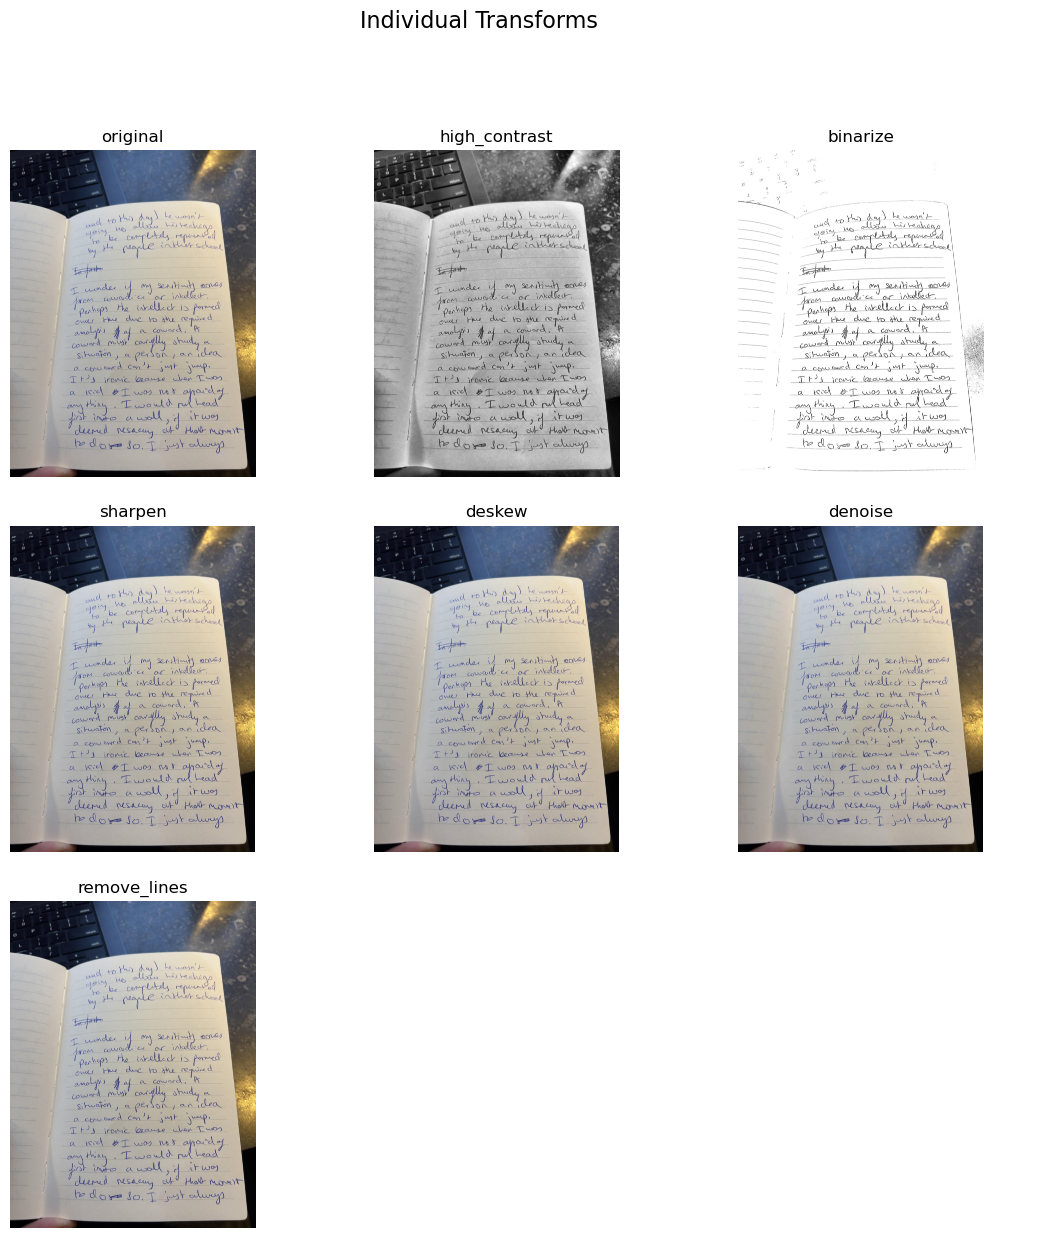

In [ ]:
individual_transforms = [
    "original", "high_contrast", "binarize",
    "sharpen", "deskew", "denoise",
    "remove_lines"
]

# --- Load images first ---
images = []
for transform in individual_transforms:
    path = preprocess_image(str(IMAGE_PATH), transform)
    img = Image.open(path).convert("RGB")
    images.append((transform, img))

# --- Find max dimensions ---
max_w = max(img.width for _, img in images)
max_h = max(img.height for _, img in images)

# --- Function to pad image to same size ---
def pad_to_size(img, width, height):
    new_img = Image.new("RGB", (width, height), (255, 255, 255))
    x = (width - img.width) // 2
    y = (height - img.height) // 2
    new_img.paste(img, (x, y))
    return new_img

# --- Plot ---
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
axes = axes.flatten()

for idx, (name, img) in enumerate(images):
    padded = pad_to_size(img, max_w, max_h)
    axes[idx].imshow(padded)
    axes[idx].set_title(name, fontsize=12)
    axes[idx].axis("off")

# Hide unused subplots
for j in range(len(images), len(axes)):
    axes[j].axis("off")

fig.suptitle("Individual Transforms", fontsize=16)
plt.subplots_adjust(wspace=0.02, hspace=0.15)
plt.show()


## 4. Step-by-Step Graph Execution

Run the graph node-by-node using `graph.stream()` to observe each state transition.

In [7]:
# Stream the graph execution — see each node fire in sequence
PREPROCESSING_STRATEGIES = [
    ["binarize", "high_contrast"],                     # good for clean scans of lined paper      # lined notebook paper
    ["deskew", "high_contrast", "binarize"],           # very faint ink
]


In [8]:
# Build initial state (same as transcribe_single)
initial_state: OCRState = {
    "image_path": str(IMAGE_PATH),
    "candidates": [],
    "critiques": [],
    "edits": [],
    "current_best": "",
    "current_score": 0.0,
    "iteration": 0,
    "max_iterations": config.MAX_ITERATIONS,
    "status": "running",
    "reason": "",
    "strategies_used": [],
    "plateau_count": 0,
    "prev_score": 0.0,
    "prev_critique": None,
    "config": {
        "accept_threshold": config.ACCEPT_THRESHOLD,
        "plateau_patience": config.PLATEAU_PATIENCE,
        "strategies": PREPROCESSING_STRATEGIES,
        "agreement_threshold": config.AGREEMENT_THRESHOLD,
    },
    "trace_events": [],
    "start_time": time.monotonic(),
}

print("Initial state keys:", list(initial_state.keys()))
print(f"Max iterations: {initial_state['max_iterations']}")
print(f"Accept threshold: {initial_state['config']['accept_threshold']}")
print(f"Strategies: {len(initial_state['config']['strategies'])}")

Initial state keys: ['image_path', 'candidates', 'critiques', 'edits', 'current_best', 'current_score', 'iteration', 'max_iterations', 'status', 'reason', 'strategies_used', 'plateau_count', 'prev_score', 'prev_critique', 'config', 'trace_events', 'start_time']
Max iterations: 10
Accept threshold: 85
Strategies: 2


In [9]:
graph = build_ocr_graph()
step_outputs = []

print("Streaming graph execution...\n")
for step in graph.stream(initial_state):
    node_name = list(step.keys())[0]
    state_update = step[node_name]
    step_outputs.append((node_name, state_update))
    
    # Print a summary of what changed
    changed_keys = list(state_update.keys())
    print(f"\n{'─'*50}")
    print(f"Node: {node_name}")
    print(f"Updated keys: {changed_keys}")
    
    if "current_best" in state_update:
        text = state_update["current_best"]
        print(f"  current_best: {text[:100]}..." if len(text) > 100 else f"  current_best: {text}")
    if "current_score" in state_update:
        print(f"  current_score: {state_update['current_score']}")
    if "status" in state_update:
        print(f"  status: {state_update['status']}")
    if "reason" in state_update:
        print(f"  reason: {state_update['reason']}")
    if "iteration" in state_update:
        print(f"  iteration: {state_update['iteration']}")

print(f"\n{'='*50}")
print(f"Execution completed. {len(step_outputs)} nodes fired.")
print(f"Nodes visited: {[name for name, _ in step_outputs]}")

Streaming graph execution...


=== PHASE 1: Initial OCR Reads ===
  [preprocess] Applying binarize+high_contrast...
[00:10] Preprocessed with 'binarize+high_contrast'
  [ocr] Running OCR on ocr_binarize+high_contrast_lzva5awg.jpg...
  [ocr] Loading allenai/olmOCR-2-7B-1025 on mps...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

  [ocr] Model loaded.
  [ocr] Done (527 chars)
[00:35] OCR pass (binarize+high_contrast) → 527 chars
  [preprocess] Applying deskew+high_contrast+binarize...
[00:36] Preprocessed with 'deskew+high_contrast+binarize'
  [ocr] Running OCR on ocr_deskew+high_contrast+binarize_0gd5s8i1.jpg...
  [ocr] Done (530 chars)
[00:45] OCR pass (deskew+high_contrast+binarize) → 530 chars
[00:45] Versions agree 99.2%
[00:45] Merged → 526 chars

--- Unloading OCR model to free memory for LLM agents ---
  [ocr] Model unloaded, memory freed.

──────────────────────────────────────────────────
Node: initial_ocr
Updated keys: ['candidates', 'current_best', 'strategies_used', 'trace_events']
  current_best: and to this day he wasn't going to allow his teachings to be completely reported by the people in ot...

=== PHASE 2: Critique-Edit Loop ===

--- Iteration 1 ---
  [critic] Analyzing transcription...
  [llm] Calling qwen3:32b (structured)...
  [critic] Verdict: needs_editing (confidence 88)
[01:15] Critic

In [21]:
# Extract final state from the last step
# Merge all step outputs to reconstruct full final state
final_state = dict(initial_state)
for node_name, state_update in step_outputs:
    final_state.update(state_update)

print(f"Final status: {final_state['status']}")
print(f"Final reason: {final_state['reason']}")
print(f"Iterations: {final_state['iteration']}")
print(f"Final confidence: {final_state['current_score']}")
print(f"Candidates: {len(final_state['candidates'])}")
print(f"Critiques: {len(final_state['critiques'])}")
print(f"Edits: {len(final_state['edits'])}")
print(f"Strategies used: {final_state['strategies_used']}")
print(f"\n--- Final Transcription ---")
print(final_state["current_best"])

Final status: completed
Final reason: accept
Iterations: 1
Final confidence: 88
Candidates: 2
Critiques: 1
Edits: 0
Strategies used: ['binarize+high_contrast', 'deskew+high_contrast+binarize']

--- Final Transcription ---
and to this day he wasn't going to allow his teachings to be completely reported by the people in other schools. In fact, I wonder if my sensitivity comes from cowardice or intellect. Perhaps the intellect is formed over time due to the required analysis of a coward. A coward must carefully study a situation, a person, an idea. A coward can't just jump. It's ironic because when I was a kid & I was not afraid of anything. I would run head first into a wall, if it was deemed necessary at that moment to do so. I just always


## 5. Full Pipeline Run (Single Invocation)

Run the entire graph in one call — equivalent to `transcribe_single()`.

In [ ]:
# Full invoke (use this if you want to skip the streaming above)
# Uncomment to run:

# graph = build_ocr_graph()
# initial_state["start_time"] = time.monotonic()  # reset timer
# final_state = graph.invoke(initial_state)
# print(f"Status: {final_state['status']}, Confidence: {final_state['current_score']}")
# print(final_state["current_best"])

## 6. Trace & Execution Analysis

Reconstruct the trace from events and visualize the pipeline execution.

In [22]:
# Reconstruct trace from final state
trace = Trace.from_events(final_state["trace_events"])
trace.print_summary()

[00:10] Preprocessed with 'binarize+high_contrast'
[00:35] OCR pass (binarize+high_contrast) → 527 chars
[00:36] Preprocessed with 'deskew+high_contrast+binarize'
[00:45] OCR pass (deskew+high_contrast+binarize) → 530 chars
[00:45] Versions agree 99.2%
[00:45] Merged → 526 chars
[01:15] Critic: confidence 88, verdict=needs_editing (2 issues: 0 critical, 1 minor, 1 cosmetic)
[01:15] DONE — 1 iterations, final confidence 88


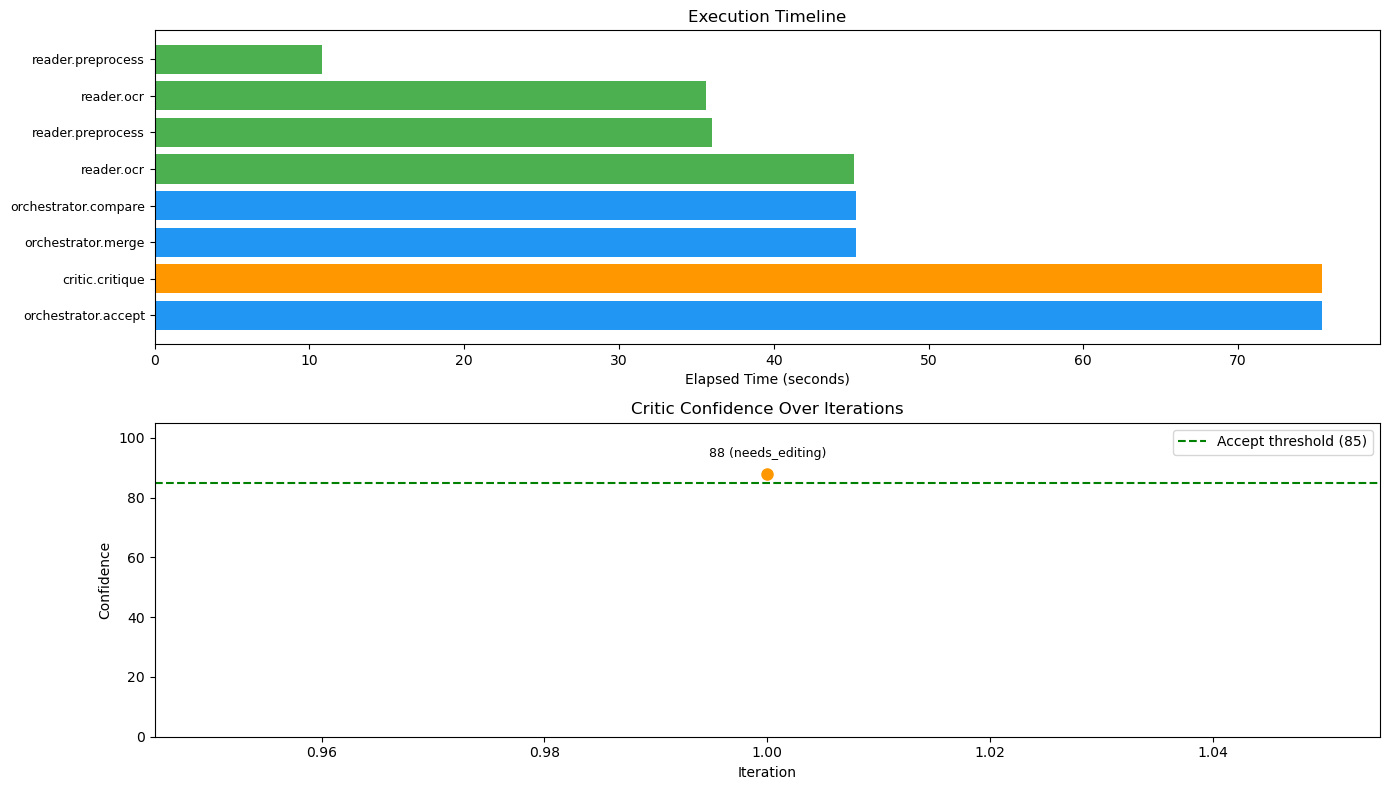

In [23]:
# Visualize execution timeline
events = final_state["trace_events"]

if events:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # --- Timeline: elapsed time per event ---
    labels = [f"{e['agent']}.{e['action']}" for e in events]
    times = [e["elapsed_seconds"] for e in events]
    colors_map = {
        "reader": "#4CAF50",
        "orchestrator": "#2196F3",
        "critic": "#FF9800",
        "editor": "#9C27B0",
        "arbitrator": "#F44336",
    }
    bar_colors = [colors_map.get(e["agent"], "#607D8B") for e in events]

    ax1.barh(range(len(events)), times, color=bar_colors)
    ax1.set_yticks(range(len(events)))
    ax1.set_yticklabels(labels, fontsize=9)
    ax1.set_xlabel("Elapsed Time (seconds)")
    ax1.set_title("Execution Timeline")
    ax1.invert_yaxis()

    # --- Confidence over iterations ---
    critic_events = [e for e in events if e["agent"] == "critic"]
    if critic_events:
        iterations = list(range(1, len(critic_events) + 1))
        confidences = [e["metrics"].get("confidence", 0) for e in critic_events]
        verdicts = [e.get("decision", "") for e in critic_events]

        ax2.plot(iterations, confidences, "o-", color="#FF9800", linewidth=2, markersize=8)
        ax2.axhline(y=config.ACCEPT_THRESHOLD, color="green", linestyle="--",
                     label=f"Accept threshold ({config.ACCEPT_THRESHOLD})")
        for i, (it, conf, v) in enumerate(zip(iterations, confidences, verdicts)):
            ax2.annotate(f"{conf} ({v})", (it, conf), textcoords="offset points",
                         xytext=(0, 12), ha="center", fontsize=9)
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Confidence")
        ax2.set_title("Critic Confidence Over Iterations")
        ax2.set_ylim(0, 105)
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "No critic events found", ha="center", va="center",
                 transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()
else:
    print("No trace events available.")

In [26]:
events[1]

{'timestamp': '2026-02-17T19:36:13.196842+00:00',
 'elapsed_seconds': 35.6,
 'iteration': 0,
 'agent': 'reader',
 'action': 'ocr',
 'input_summary': 'Preprocessed image (binarize+high_contrast)',
 'output_summary': 'OCR pass (binarize+high_contrast) → 527 chars',
 'full_input': {},
 'full_output': {'text_preview': "and to this day he wasn't going to allow his teachings to be completely reported by the people in other schools.\n\nIn fact, I wonder if my sensitivity comes from cowardice or intellect. Perhaps the int"},
 'metrics': {'chars': 527, 'strategy': 'binarize+high_contrast'},
 'decision': None}

In [24]:
# Inspect individual events in detail
for i, event in enumerate(events):
    print(f"\n--- Event {i} ---")
    print(f"  Agent: {event['agent']}")
    print(f"  Action: {event['action']}")
    print(f"  Elapsed: {event['elapsed_seconds']}s")
    print(f"  Output: {event['output_summary']}")
    if event.get("metrics"):
        print(f"  Metrics: {json.dumps(event['metrics'], indent=4)}")
    if event.get("decision"):
        print(f"  Decision: {event['decision']}")


--- Event 0 ---
  Agent: reader
  Action: preprocess
  Elapsed: 10.8s
  Output: Preprocessed with 'binarize+high_contrast'
  Metrics: {
    "strategy": "binarize+high_contrast"
}

--- Event 1 ---
  Agent: reader
  Action: ocr
  Elapsed: 35.6s
  Output: OCR pass (binarize+high_contrast) → 527 chars
  Metrics: {
    "chars": 527,
    "strategy": "binarize+high_contrast"
}

--- Event 2 ---
  Agent: reader
  Action: preprocess
  Elapsed: 36.0s
  Output: Preprocessed with 'deskew+high_contrast+binarize'
  Metrics: {
    "strategy": "deskew+high_contrast+binarize"
}

--- Event 3 ---
  Agent: reader
  Action: ocr
  Elapsed: 45.2s
  Output: OCR pass (deskew+high_contrast+binarize) → 530 chars
  Metrics: {
    "chars": 530,
    "strategy": "deskew+high_contrast+binarize"
}

--- Event 4 ---
  Agent: orchestrator
  Action: compare
  Elapsed: 45.3s
  Output: Versions agree 99.2%
  Metrics: {
    "agreement_rate": 99.2
}
  Decision: merge

--- Event 5 ---
  Agent: orchestrator
  Action: merge
  El

In [ ]:
# Compare OCR candidates from initial reads
candidates = final_state["candidates"]
if len(candidates) >= 2:
    cmp = compare_versions(candidates[0]["text"], candidates[1]["text"])
    print(f"Agreement rate: {cmp['agreement_rate']}%")
    print(f"Char edit distance: {cmp['char_edit_distance']}")
    print(f"Word edit distance: {cmp['word_edit_distance']}")
    if cmp["differing_segments"]:
        print(f"\nDiffering segments ({len(cmp['differing_segments'])}):\n")
        for seg in cmp["differing_segments"]:
            print(f"  pos {seg['position']}: '{seg['v1_text']}' vs '{seg['v2_text']}'")
else:
    print(f"Only {len(candidates)} candidate(s) — nothing to compare.")

In [ ]:
# Inspect critic results
for i, critique in enumerate(final_state["critiques"]):
    print(f"\n=== Critique {i+1} ===")
    print(f"  Overall confidence: {critique['overall_confidence']}")
    print(f"  Verdict: {critique['verdict']}")
    print(f"  Reasoning: {critique['reasoning']}")
    for seg in critique["segments"]:
        if seg["issues"]:
            print(f"  Segment: '{seg['text'][:60]}...'")
            for issue in seg["issues"]:
                print(f"    [{issue['severity']}] {issue['description']}")
                print(f"      Suggestion: {issue['suggestion']}")

In [ ]:
# Inspect editor results
for i, edit in enumerate(final_state["edits"]):
    print(f"\n=== Edit {i+1} ===")
    print(f"  Changes made: {len(edit['changes'])}")
    for change in edit["changes"]:
        print(f"    '{change['original']}' → '{change['corrected']}'")
        print(f"      Reason: {change['reason']} (confidence: {change['confidence']})")
    if edit["unresolved"]:
        print(f"  Unresolved: {edit['unresolved']}")

## 7. Evaluation (CER, WER, LLM Correction)

Evaluate the final transcription against ground truth (if available) and run LLM correction.

In [ ]:
# If you have a ground truth file, load it
ground_truth = None
if GROUND_TRUTH_PATH and Path(GROUND_TRUTH_PATH).exists():
    from ocr_agent.tools import parse_ground_truth
    ground_truth = parse_ground_truth(GROUND_TRUTH_PATH)
    print(f"Ground truth loaded ({len(ground_truth)} chars)")
    print(f"Preview: {ground_truth[:200]}...")
else:
    print("No ground truth file — skipping GT-based metrics.")
    print("Set GROUND_TRUTH_PATH in cell 2 to enable CER/WER computation.")

In [ ]:
# Run full evaluation
transcription = final_state["current_best"]

eval_result = evaluate(transcription, ground_truth=ground_truth)
eval_result["pipeline_status"] = final_state["status"]
eval_result["iterations"] = final_state["iteration"]
eval_result["final_confidence"] = final_state["current_score"]

print(json.dumps(eval_result, indent=2, ensure_ascii=False))

In [ ]:
# Visualize metrics (when ground truth is available)
if ground_truth:
    raw_metrics = eval_result.get("tier1_raw_vs_gt", {})
    corrected_metrics = eval_result.get("tier1_corrected_vs_gt", {})

    metric_names = ["CER", "WER (char)", "WER (token)"]
    raw_vals = [raw_metrics.get("cer", 0), raw_metrics.get("wer", 0), raw_metrics.get("wer_token", 0)]

    fig, ax = plt.subplots(figsize=(10, 5))
    x = range(len(metric_names))
    width = 0.35

    bars1 = ax.bar([i - width/2 for i in x], raw_vals, width, label="Raw OCR", color="#FF9800")

    if corrected_metrics:
        corr_vals = [corrected_metrics.get("cer", 0), corrected_metrics.get("wer", 0),
                     corrected_metrics.get("wer_token", 0)]
        bars2 = ax.bar([i + width/2 for i in x], corr_vals, width, label="LLM Corrected", color="#4CAF50")

    ax.set_ylabel("Error Rate")
    ax.set_title("OCR Error Rates: Raw vs LLM-Corrected")
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()
    ax.set_ylim(0, max(raw_vals + [0.1]) * 1.3)

    # Add value labels
    for bar in bars1:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h, f"{h:.3f}",
                ha="center", va="bottom", fontsize=10)
    if corrected_metrics:
        for bar in bars2:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., h, f"{h:.3f}",
                    ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No ground truth — cannot compute CER/WER.")
    print("\nPipeline evaluation summary:")
    print(f"  Status: {eval_result['pipeline_status']}")
    print(f"  Iterations: {eval_result['iterations']}")
    print(f"  Final confidence: {eval_result['final_confidence']}")
    if "corrected_text" in eval_result:
        print(f"\nLLM-corrected transcription:")
        print(eval_result["corrected_text"])

In [ ]:
# Compare raw pipeline output vs LLM-corrected output
if "corrected_text" in eval_result:
    raw = normalize_text(transcription)
    corrected = normalize_text(eval_result["corrected_text"])
    cmp = compare_versions(raw, corrected)
    print(f"Agreement between pipeline output and LLM correction: {cmp['agreement_rate']}%")
    print(f"Char edits: {cmp['char_edit_distance']}, Word edits: {cmp['word_edit_distance']}")
    if cmp["differing_segments"]:
        print(f"\nDifferences ({len(cmp['differing_segments'])}):\n")
        for seg in cmp["differing_segments"]:
            print(f"  Pipeline: '{seg['v1_text']}'")
            print(f"  LLM fix:  '{seg['v2_text']}'\n")

## 8. Load & Analyze Previous Runs

Load saved trace/eval files from previous pipeline runs.

In [ ]:
# Load a previous trace
trace_path = PROJECT_ROOT / "data" / "input" / "test_notes_trace.json"
eval_path = PROJECT_ROOT / "data" / "input" / "test_notes_eval.json"

if trace_path.exists():
    with open(trace_path) as f:
        saved_events = json.load(f)
    saved_trace = Trace.from_events(saved_events)
    print(f"Loaded trace with {len(saved_events)} events")
    saved_trace.print_summary()
else:
    print(f"No saved trace at {trace_path}")

if eval_path.exists():
    with open(eval_path) as f:
        saved_eval = json.load(f)
    print(f"\nSaved evaluation:")
    print(json.dumps(saved_eval, indent=2, ensure_ascii=False))
else:
    print(f"No saved eval at {eval_path}")